In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import torch
import xarray as xr
import pandas as pd
import os

import cartopy
import cartopy.crs as ccrs
from pyresample import load_area, geometry

import quantnn

In [2]:
data = xr.load_dataset('../reference/rain_gauge_preds/2020030304.nc')

In [3]:
data

<xarray.Dataset>
Dimensions:                  (x: 1024, y: 1024)
Dimensions without coordinates: x, y
Data variables:
    xception_posterior_mean  (y, x) float32 1.979 2.32 ... 0.0005488 0.0005485
    xception_Q0.95           (y, x) float32 7.966 9.096 ... 0.0009375 0.0009376
    xception_Q0.99           (y, x) float32 15.53 17.29 ... 0.001 0.0009918
    mlp_posterior_mean       (y, x) float32 1.655 1.835 ... 0.0005519 0.0005519
    mlp_Q0.95                (y, x) float32 0.0005823 0.0005914 ... 0.0001181
    mlp_Q0.99                (y, x) float32 0.0005793 0.0005887 ... 0.0009936
Attributes:
    ind_extent:   [1344 2217 2368 1193]
    area_extent:  [  -46092.39762437 -3452921.78725195  4058135.00823285   65...
    shape:        [1024 1024]
    start:        2020-03-03 04:00:00
    end:          2020-03-03 05:00:00
    datetimes:    ['[datetime.datetime(2020, 3, 3, 4, 0, 17), datetime.dateti...

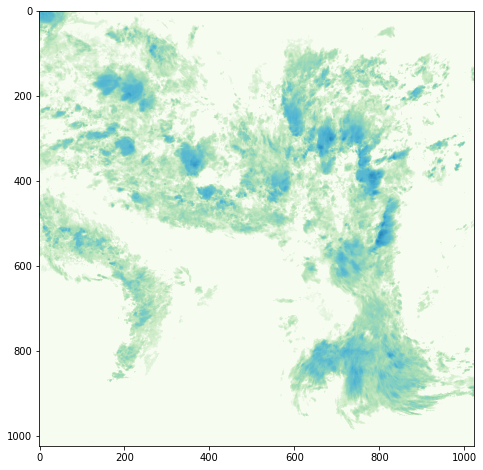

In [4]:
precip_norm = LogNorm(1e-2, 1e2)
fig, ax = plt.subplots(figsize=(8,8))
ax.imshow(data.mlp_posterior_mean, norm=precip_norm, cmap=plt.get_cmap('GnBu'))

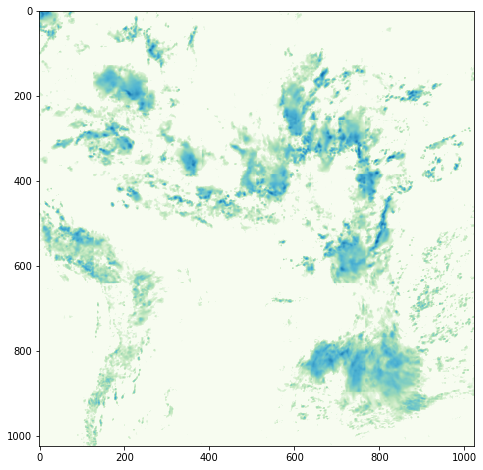

In [5]:
fig, ax = plt.subplots(figsize=(8,8))
ax.imshow(data.xception_posterior_mean, norm=precip_norm, cmap=plt.get_cmap('GnBu'))

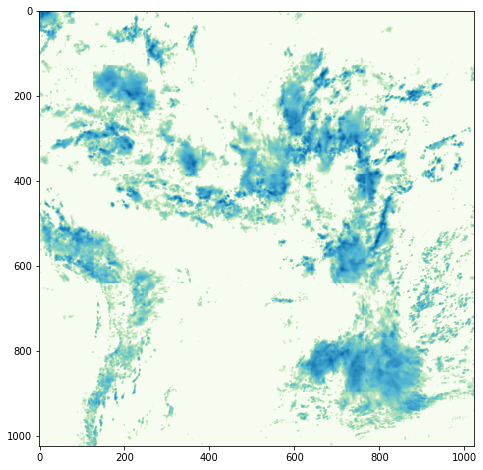

In [6]:
fig, ax = plt.subplots(figsize=(8,8))
ax.imshow(data['xception_Q0.95'], norm=precip_norm, cmap=plt.get_cmap('GnBu'))

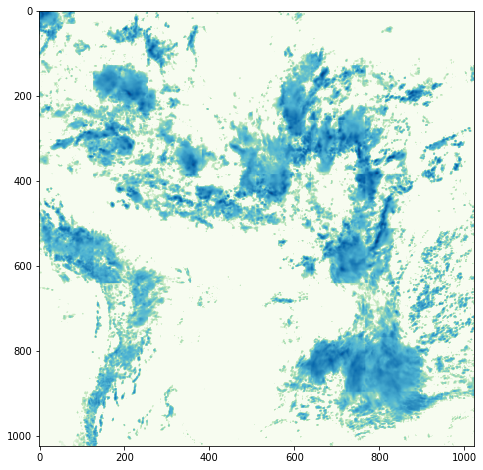

In [7]:
fig, ax = plt.subplots(figsize=(8,8))
ax.imshow(data['xception_Q0.99'], norm=precip_norm, cmap=plt.get_cmap('GnBu'))

In [8]:
def get_gauge_locations(path_to_rain_gauge_data, region_ind_extent):
	#region_corners_idx_low, __, __, region_corners_idy_low = region_ind_extent
	lonlats = pd.read_pickle(os.path.join(path_to_rain_gauge_data,'rain_gauge_locs.pckl'))
	colrows = []
	for lon, lat in zip(lonlats['lon'], lonlats['lat']):
		col, row = area_def.lonlat2colrow(lon, lat)
		#colrows.append((col-region_corners_idx_low, row-region_corners_idy_low))
		colrows.append((col, row))

	colrows = pd.DataFrame(colrows, columns = ['cols', 'rows'])
	
	return(colrows)

In [9]:
path_to_rain_gauge_data = '../reference/'
region_ind_extent = data.ind_extent
area_path='../dataset/downloads/files/areas.yaml'
area_def = load_area(area_path, 'full_disk')
gauge_locs = get_gauge_locations(path_to_rain_gauge_data, region_ind_extent)

/home/ingrid/anaconda/envs/geostat/lib/python3.8/site-packages/pyproj/crs/crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = self.to_proj4()


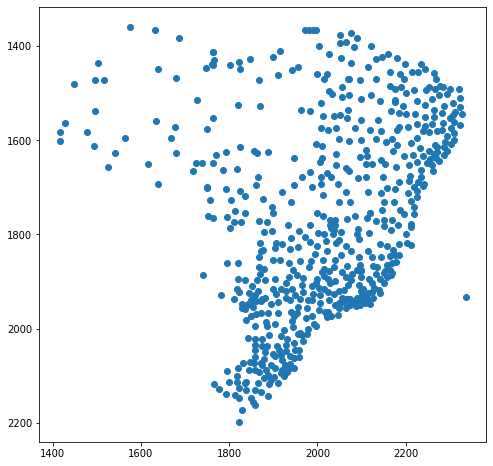

In [10]:
fig, ax = plt.subplots(figsize=(8,8))
ax.invert_yaxis()
plt.scatter(gauge_locs.cols, gauge_locs.rows)

/home/ingrid/anaconda/envs/geostat/lib/python3.8/site-packages/pyproj/crs/crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = self.to_proj4()


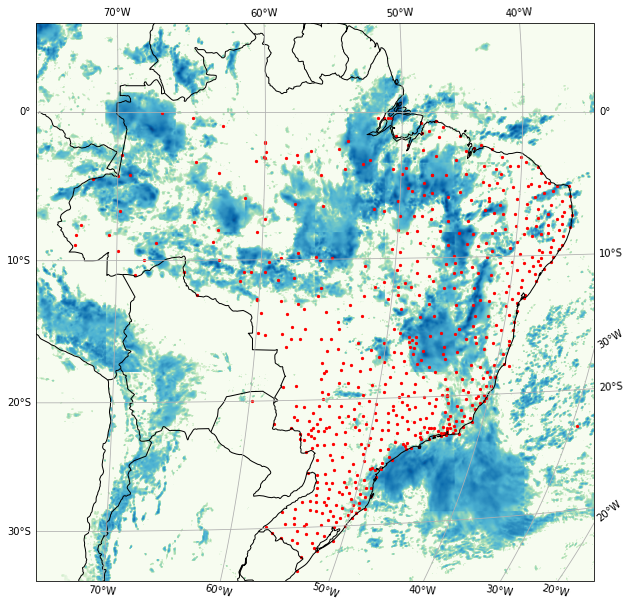

In [11]:
projcoords_x, projcoords_y = area_def.get_proj_vectors()
projcoords_mat_x, projcoords_mat_y = area_def.get_proj_coords()

area_def_ext_region = area_def.copy(area_extent = data.area_extent,
                                                  height = data.shape[0], 
                                                  width = data.shape[1])
crs = area_def_ext_region.to_cartopy_crs()
fig, ax = plt.subplots(subplot_kw={'projection': crs}, figsize = (10,11))
ax.scatter(x=projcoords_mat_x[gauge_locs.rows, gauge_locs.cols], 
           y=projcoords_mat_y[gauge_locs.rows, gauge_locs.cols], transform=crs, s=5, color='red')
ax.imshow(data['xception_Q0.99'], extent=crs.bounds, origin='upper', norm=precip_norm, transform=crs, cmap=plt.get_cmap('GnBu'))
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.add_feature(cartopy.feature.BORDERS)
ax.set_global()
#ax.title.set_text(plot_title)
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.show()

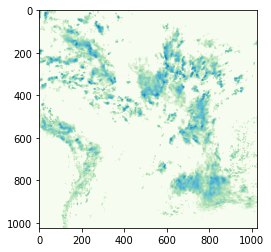

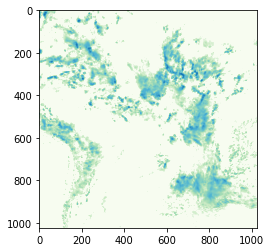

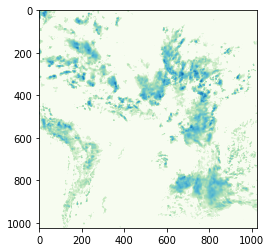

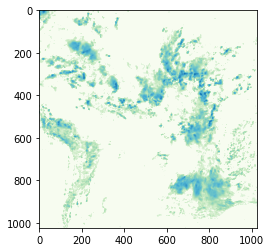

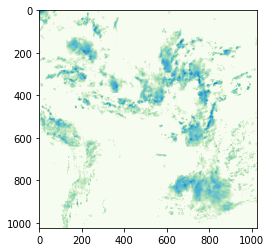

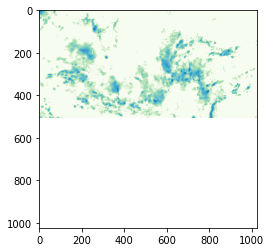

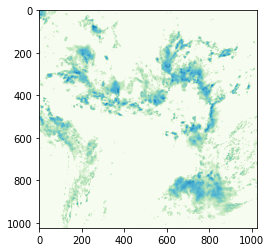

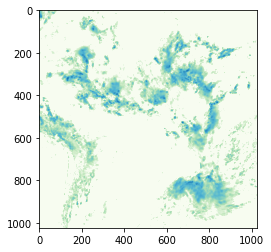

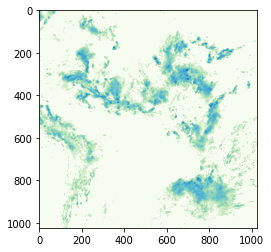

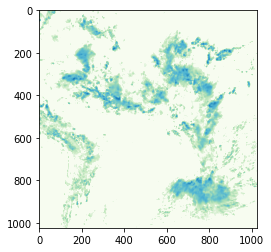

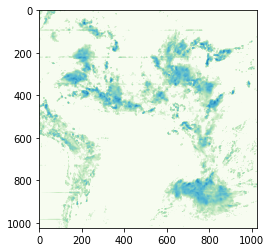

In [12]:
ind=0
single_obs_posterior_mean = []
single_obs95 = []
single_obs99 = []
region_corners_idx_low, __, __, region_corners_idy_low = region_ind_extent
for i in range(0,11):
    data = xr.load_dataset('../reference/rain_gauge_preds/20200303'+str(i).zfill(2)+'.nc')
    fig, ax = plt.subplots(num=i)
    ax.imshow(data.xception_posterior_mean, norm=precip_norm, cmap=plt.get_cmap('GnBu'))
    single_obs_posterior_mean.append(data.xception_posterior_mean[gauge_locs.cols[ind]-region_corners_idx_low, 
                                                   gauge_locs.rows[ind]-region_corners_idy_low])
    single_obs95.append(data['xception_Q0.95'][gauge_locs.cols[ind]-region_corners_idx_low, 
                                                   gauge_locs.rows[ind]-region_corners_idy_low])
    single_obs99.append(data['xception_Q0.99'][gauge_locs.cols[ind]-region_corners_idx_low, 
                                                   gauge_locs.rows[ind]-region_corners_idy_low])

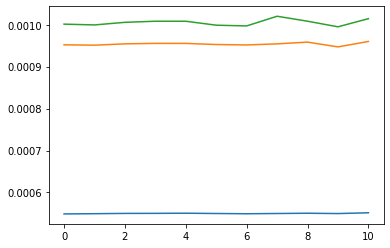

In [13]:
plt.plot(single_obs_posterior_mean)
plt.plot(single_obs95)
plt.plot(single_obs99)
plt.show()